In [1]:
import numpy as np
import matplotlib.pyplot as plt

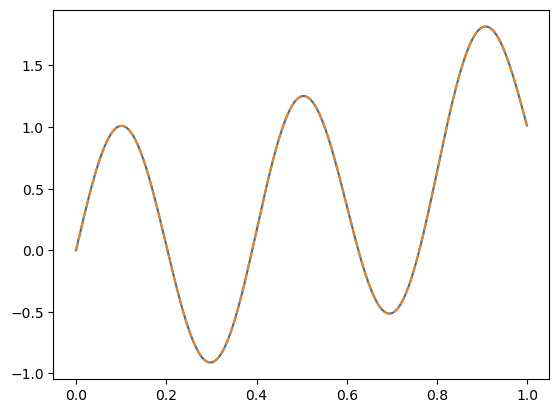

In [2]:
# Chebyshev Lobatto grid points
c_a_N = lambda alpha, N: 0.5*(np.cos(np.pi*alpha/N)+1) #alpha index for grid points (from 0 to N = number of grid points)
#grid points defined in interval [0,1]

# Here we construct the Chebyshev polynomials from trigonometric functions
# See 'Cardinal functions' in https://deepblue.lib.umich.edu/handle/2027.42/29694
def C_Fourier_0_N(x, N): #cardinal function C_0, N number of points?
    result = np.zeros(x.shape)
    result[np.abs(x)> 1e-16] = np.sin(N*x[np.abs(x)>1e-16])/np.tan(x[np.abs(x)>1e-16]/2)/(2*N)
    result[np.abs(x)<=1e-16] = 1.
    return result
C_Fourier_j_N = lambda x, j, N: C_Fourier_0_N(x-j*np.pi/N, N) #C_j's are just translated versions of C_0
C_Chebysh_j_N = lambda x, j, N: (C_Fourier_j_N(np.arccos(x), j, N) + C_Fourier_j_N(np.arccos(x), -j, N))/(1 + (j==0 or j==N))
# The following P_a_N are the Chebyshev polynomials used in arxiv:2311.12554
P_a_N = lambda x, alpha, N: C_Chebysh_j_N(2*x-1, alpha, N)
#transformation 2*x-1 maps interval [0,1] to interval [-1,1] to work with Chebyshev polyn.

# define function that constructs MPS tensors of Chebyshev interpolation
def Chebyshev_interpolation(func, L, chi):
    N = chi-1 #sets number of polynomials
    args = 0.5 * (np.arange(2)[:, None] + c_a_N(np.arange(N+1), N)[None, :]) # see Eqs. (4.1) and (4.2)
    As = [] #list that will store tensors of MPS representation
    # construct (data-dependent) left tensor
    A = func(args)[None] # (1, 2, chi)
    As.append(A)
    # construct (data-independent) bulk tensors from Chebyshev polynomials
    for i in range(1, L-1):
        A = np.array([P_a_N(args, alpha, N) for alpha in range(N+1)]) # (chi, 2, chi)
        As.append(A)
    # construct (data-independent) final tensor from Chebyshev polynomials
    A = np.array([P_a_N(np.arange(2)/2, alpha, N) for alpha in range(N+1)])[:, :, None] # (chi, 2, 1)
    As.append(A)
    return As

# Example: create a function to interpolate
test_func = lambda x: np.sin(5*np.pi*x) + x**2

# MPS from Chebyshev interpolation
As = Chebyshev_interpolation(test_func, # function to be interpolated
                             L=10,      # number of MPS tensors
                             chi=15)    # bond dimension

# Plot function and interpolation below

# contract full MPS (should only do this for small L <= 20)
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = test_func(xs)

# plot result
plt.plot(xs, func_vals, '-')
plt.plot(xs, func_interp, '--')
plt.show()

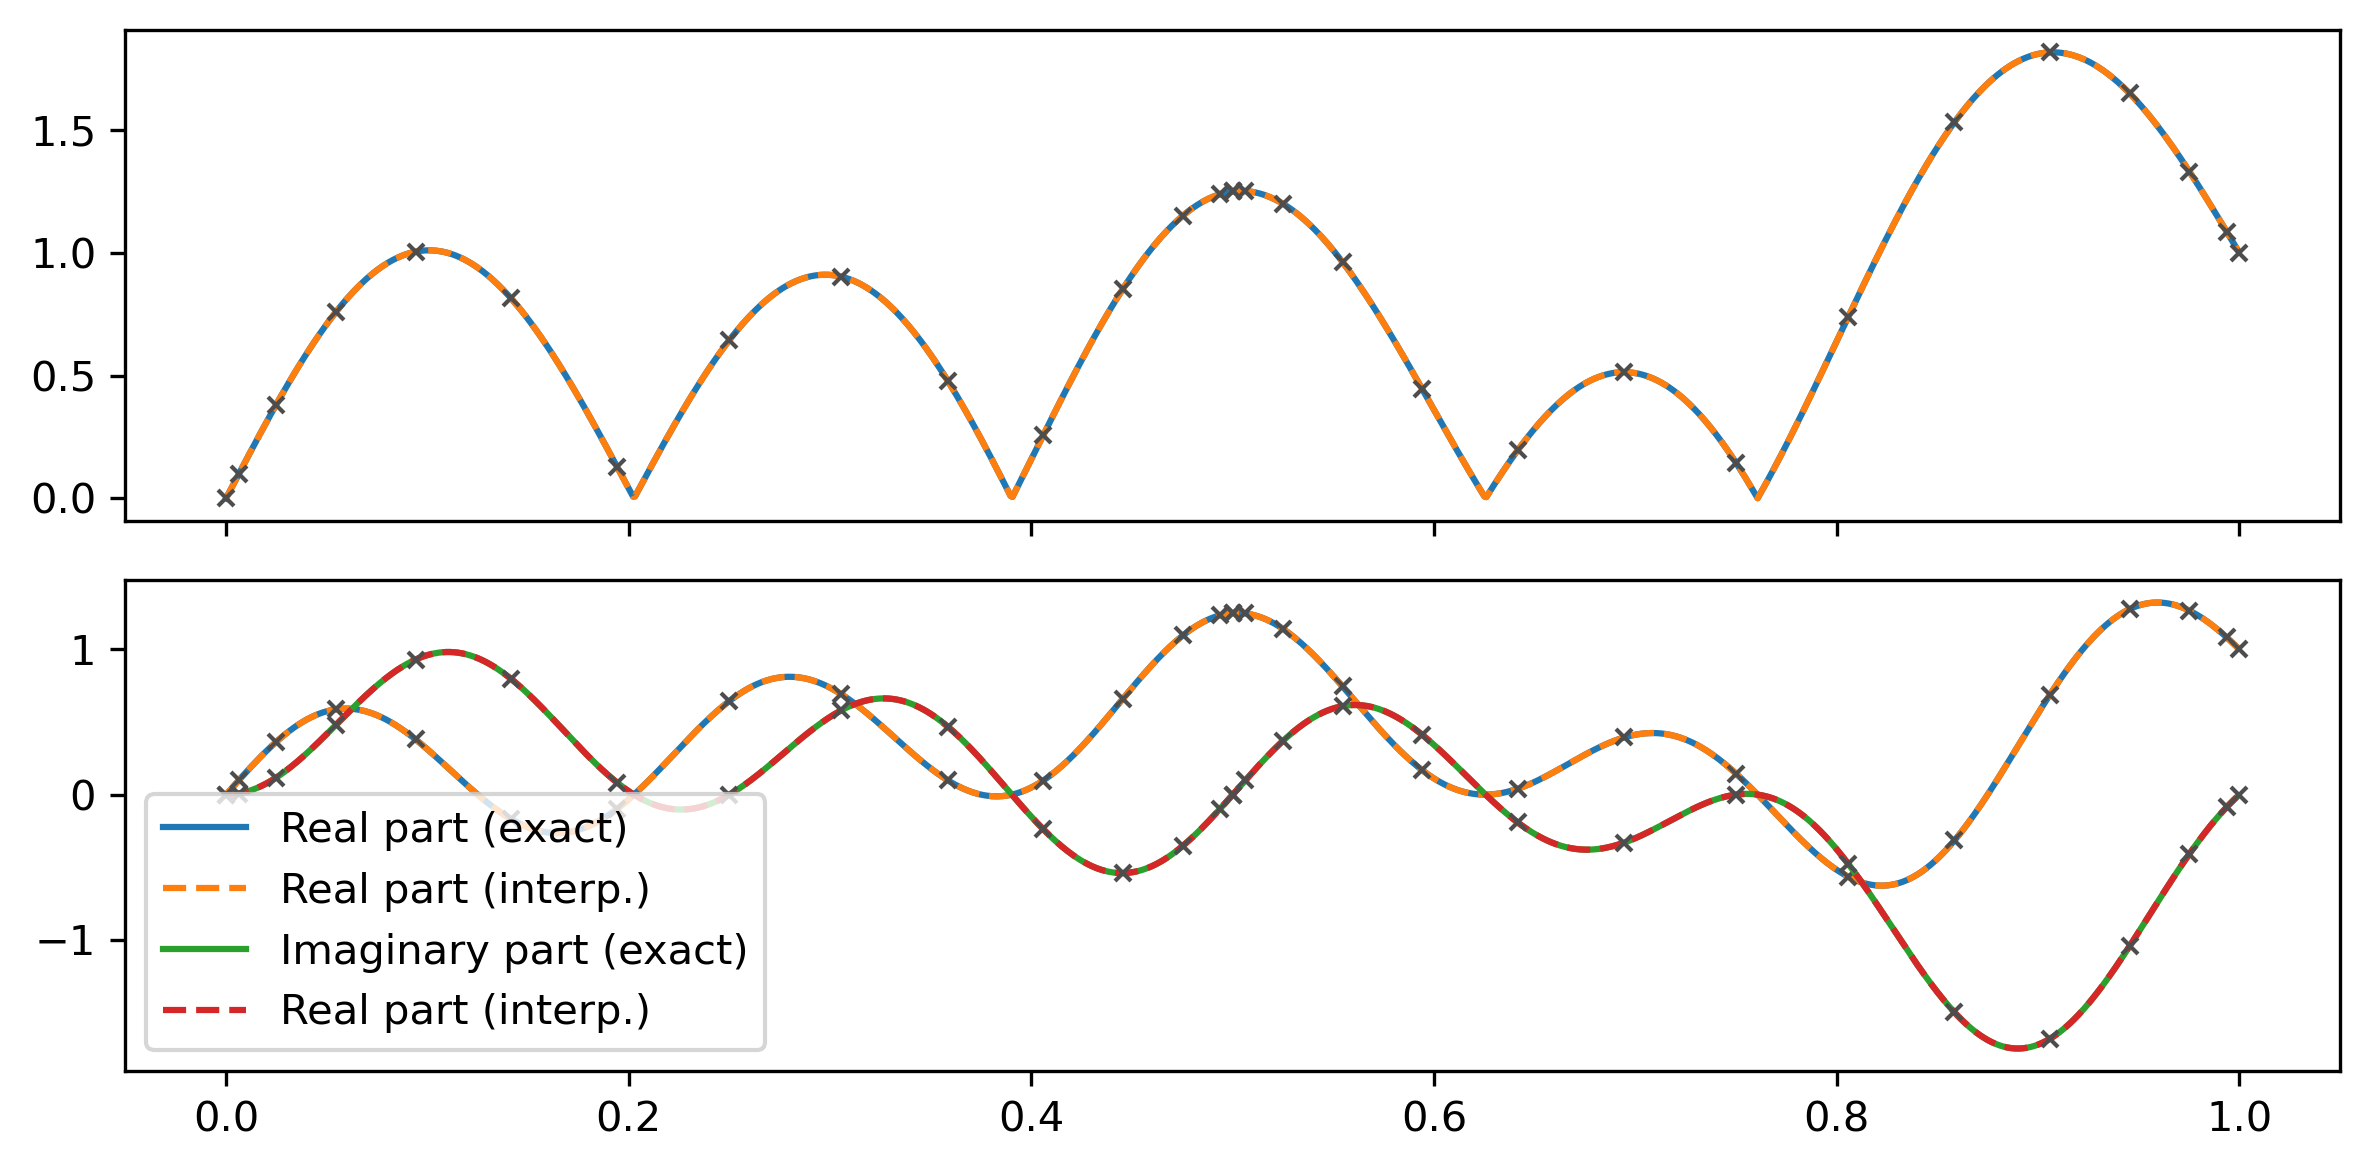

In [5]:
# The above only worked for real functions, so here we generalize to complex functions
# The idea is to do a Chebyshev interpolation for the real and imaginary part separately
# and add the two MPS representations together

def complex_Chebyshev_interpolation(func, L, chi):
    N = chi-1
    args = 0.5 * (np.arange(2)[:, None] + c_a_N(np.arange(N+1), N)[None, :])
    As = []
    # construct (data-dependent) left tensor
    func_vals = func(args) # (2, chi)
    A = np.append(func_vals.real, 1j*func_vals.imag, axis=1)[None] # (1, 2, 2*chi)
    As.append(A)
    # construct (data-independent) bulk tensors from Chebyshev polynomials
    for i in range(1, L-1):
        Cheb_vals = np.array([P_a_N(args, alpha, N) for alpha in range(N+1)]) # (chi, 2, chi)
        A = np.zeros((2*chi, 2, 2*chi), dtype=np.float64) # (2*chi, 2, 2*chi)
        A[:chi, :, :chi] = Cheb_vals
        A[chi:, :, chi:] = Cheb_vals
        As.append(A)
    # construct (data-independent) final tensor from Chebyshev polynomials
    Cheb_vals = np.array([P_a_N(np.arange(2)/2, alpha, N) for alpha in range(N+1)])[:, :, None] # (chi, 2, 1)
    A = np.zeros((2*chi, 2, 1), dtype=np.float64) # (2*chi, 2, 1)
    A[:chi, :, :] = Cheb_vals
    A[chi:, :, :] = Cheb_vals
    As.append(A)
    return As

# Example: create complex-valued test function
complex_test_func = lambda x: (np.sin(5*np.pi*x) + x**2) * np.exp(1j*4*np.pi*x)

# get MPS from Chebyshev interpolation
chi = 15
As = complex_Chebyshev_interpolation(complex_test_func, # function to be interpolated
                                     L=10,              # number of MPS tensors
                                     chi=chi)           # (half of the) bond dimension
# also plot points on which the function was evaluated
Cheb_xs = 0.5 * np.sort(np.arange(2)[:, None] + c_a_N(np.arange(chi), chi-1)[None, :])
Cheb_vals = complex_test_func(Cheb_xs)

# contract MPS to reconstruct interpolated function
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = complex_test_func(xs)

# plot results
fig, axs = plt.subplots(nrows=2, dpi=300, figsize=(8,4), sharex=True)

axs[0].plot(xs, np.abs(func_vals))
axs[0].plot(xs, np.abs(func_interp), '--')
axs[0].plot(Cheb_xs, np.abs(Cheb_vals), 'x', ms=4, color='0.3')

axs[1].plot(xs, func_vals.real, label='Real part (exact)')
axs[1].plot(xs, func_interp.real, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.real, 'x', ms=4, color='0.3')
axs[1].plot(xs, func_vals.imag, label='Imaginary part (exact)')
axs[1].plot(xs, func_interp.imag, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.imag, 'x', ms=4, color='0.3')
axs[1].legend()

plt.tight_layout()
plt.show()